# Capstone Project - Week 5 Final Report

### Opening a Grocery Store in Toronto, Canada

**Goal:** 

* Build a dataframe of neighborhoods and boroughs in Toronto, Canada.
* Obtain the geographical coordinates of the neighborhoods.
* Get the venue data for the neighborhoods from Foursquare API.
* Analyze and cluster the neighborhoods by kmeans clustering.
* Select the best cluster to open a new grocery store.

## 1. Import libraries

In [55]:
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("Libraries imported")

Libraries imported


## 2. Data acquisition and cleaning

## 2.1 Data Sources

a) Toronto City data. 
* Data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* Description: The data contains the postal code, borough & the name of all the neighborhoods present in Toronto.

b) Geospace data for each neighborhood in Toronto City.
* Data source: http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv file
* Description: The data contains the geographical coordinates i.e. latitudes and longitudes of the neighborhoods. 

c) Venue data, particularly data related to grocery store. 
* Data source: https://developer.foursquare.com/docs
* Description: FourSquare’s explore API gives details such as names, categories and locations (latitude and longitude).


## 2.2 Data Preparation & Cleaning 

**a) Scraping Toronto Neighborhoods table from the following Wikipedia page, “List of Postal code of Canada: M”**

Assumptions made to attain the below DataFrame:

- Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignored.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [6]:
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(website_url,'html.parser')

In [7]:
df=pd.read_html(str(soup))[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [8]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df = df.rename(columns={'Postcode': 'Postalcode'})

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
#So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']


df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [9]:
# Group by Neighbourhoods
df = df.groupby(['Borough','Postalcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postalcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


**b) Adding geographical coordinates to the neighborhoods**

Next is adding the geographical coordinates to these neighborhoods. To do so, extracting the data present in the Geospatial Cordinates csv file and combining it with the existing neighborhood dataframe by merging them both based on the postal code.

In [10]:
df_lat_long = pd.read_csv("http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv",header=0)
df_lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Renaming the columns to match the existing dataframe
df_lat_long = df_lat_long.rename(columns={'Postal Code': 'Postalcode'})
df_lat_long.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
# Merging both the dataframe "df" and "df_lat_long"into one by matching on the postal code.
df_toronto = pd.merge(df, df_lat_long, how='left', left_on = 'Postalcode', right_on = 'Postalcode')

# Renaming the columns to match the existing dataframe
df_toronto = df_toronto.rename(columns={'Neighbourhood':'Neighborhood'})

df_toronto.head()

,Borough,Postalcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [13]:
#Use geopy library to get the latitude and longitude values of toronto.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
CLIENT_ID = 'D2TCCXOXA15ZLJGYJ5A0OK0AIMGFG4U5XQ3DUMPZPXZOP403' # your Foursquare ID
CLIENT_SECRET = 'ZZQPKCLI1P1LFAFKKIB0CDCVCIUM1MPMSZ4NSW3BOLGSP2IK' # your Foursquare Secret
VERSION = '20180605'
LIMIT=100
radius=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D2TCCXOXA15ZLJGYJ5A0OK0AIMGFG4U5XQ3DUMPZPXZOP403
CLIENT_SECRET:ZZQPKCLI1P1LFAFKKIB0CDCVCIUM1MPMSZ4NSW3BOLGSP2IK


**c) Get location data using Foursquare**

Foursquare API is very useful online application used my many developers & other application like Uber etc. The API returns a JSON file and later we need to turn that into a data-frame. 

**Use the Foursquare API to explore the neighborhoods**

# 3. Visualization and Exploratory Data Analysis

## 3.1 Exploring the neighborhoods using Foresquare API

**Now, let's get the most popular 100 venues that are in within a radius of 1000 meters.**

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue names, category, venue latitude and venue logitude.

In [15]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Rolltation,Japanese Restaurant,43.654918,-79.387424
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Nathan Phillips Square,Plaza,43.652270,-79.383516


## Explore the nearby venues!

In [16]:
# Creating a function to find the nearby venues on all the neighborhoods in Toronto


def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
         #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # get all the data
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
#Running the above function on each neighborhood of toronto and creating a new dataframe called toronto_venues .
LIMIT=100
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'],
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens, Parkview Hill
Woodbine Heights
Leaside
Thorncl

In [18]:
toronto_venues.head(5)

,Neighborhood,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.72802,-79.38879,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.72802,-79.38879,Granite Club,43.733043,-79.381986,Gym / Fitness Center
2,Lawrence Park,43.72802,-79.38879,Tim Hortons,43.727324,-79.379563,Coffee Shop
3,Lawrence Park,43.72802,-79.38879,Granite Club President's Lounge,43.733005,-79.382059,Café
4,Lawrence Park,43.72802,-79.38879,Glendon Bookstore,43.727024,-79.378976,Bookstore


** Check how many venues were returned for each neighorhood**

In [19]:
toronto_venues.groupby('Neighborhood').count().head()

,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,52,52,52,52,52,52
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",29,29,29,29,29,29
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",18,18,18,18,18,18
"Alderwood, Long Branch",26,26,26,26,26,26


In [20]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 328 uniques categories.


In [21]:
# print out the list of first 30 categories
toronto_venues['Venue Category'].unique()[:30]

array(['Park', 'Gym / Fitness Center', 'Coffee Shop', 'Café', 'Bookstore',
       'Trail', 'College Quad', 'College Gym', 'Food & Drink Shop',
       'Supermarket', 'Bakery', 'Italian Restaurant', 'Tea Room',
       'Brewery', 'Yoga Studio', 'Breakfast Spot', 'Sushi Restaurant',
       'Vegetarian / Vegan Restaurant', 'Dessert Shop', 'Pizza Place',
       'Ramen Restaurant', 'Wine Bar', 'Deli / Bodega', 'Gym',
       'Grocery Store', 'Taco Place', 'Vietnamese Restaurant', 'Plaza',
       'Gastropub', 'Track'], dtype=object)

From the above analysis, it is found that there are 328 unique categories in which Grocery Store is one of them. Next, we will do one hot encoding for getting dummies of venue category. Then, we will calculate mean of all venue groupby there neighborhoods.

### Analyze Neighbourhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(4940, 328)


,Zoo,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(101, 328)


,Neighborhood,Zoo,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [24]:
venue_counts = toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Zoo,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Agincourt,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### create a new DataFrame for Grocery Store data only

In [25]:
toronto_grocerystore = toronto_grouped[["Neighborhood","Grocery Store"]]
toronto_grocerystore.head()

,Neighborhood,Grocery Store
0,"Adelaide, King, Richmond",0.000000
1,Agincourt,0.019231
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.166667
4,"Alderwood, Long Branch",0.038462


### List the top 20 categories in Toronto

In [26]:
venue_counts_described = venue_counts.describe().transpose()

venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:30]
venue_top10


,count,mean,std,min,25%,50%,75%,max
Coffee Shop,101.0,3.683168,3.199783,0.0,1.0,3.0,5.0,16.0
Greek Restaurant,101.0,0.336634,1.409094,0.0,0.0,0.0,0.0,13.0
Korean Restaurant,101.0,0.297030,1.360475,0.0,0.0,0.0,0.0,12.0
Bar,101.0,0.752475,1.722823,0.0,0.0,0.0,1.0,10.0
Café,101.0,2.079208,2.693263,0.0,0.0,1.0,3.0,9.0
Italian Restaurant,101.0,1.168317,1.503791,0.0,0.0,1.0,2.0,8.0
Pub,101.0,0.584158,1.193879,0.0,0.0,0.0,1.0,8.0
Hotel,101.0,0.683168,1.624381,0.0,0.0,0.0,0.0,7.0
Indian Restaurant,101.0,0.455446,0.995236,0.0,0.0,0.0,1.0,7.0
Park,101.0,1.514851,1.323736,0.0,1.0,1.0,2.0,6.0


From the above top 20 categories,it is being analyzed that Grocery store is also among top 20 categories.

The top 20 ‘Venue Categories’ can also be found by counting their occurrences. This analysis is depicted below which shows that ‘ Grocery Store’is among the top 20.

In [27]:
Toronto_Venues_Top20 = toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top20 =Toronto_Venues_Top20.reset_index()
#Toronto_Venues_Top20

Toronto_Venues_Top20.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top20

,Venue_Category,Frequency
0,Coffee Shop,372
1,Café,210
2,Park,153
3,Pizza Place,151
4,Restaurant,120
5,Italian Restaurant,118
6,Bakery,107
7,Grocery Store,88
8,Japanese Restaurant,81
9,Sushi Restaurant,78


### Bar chart

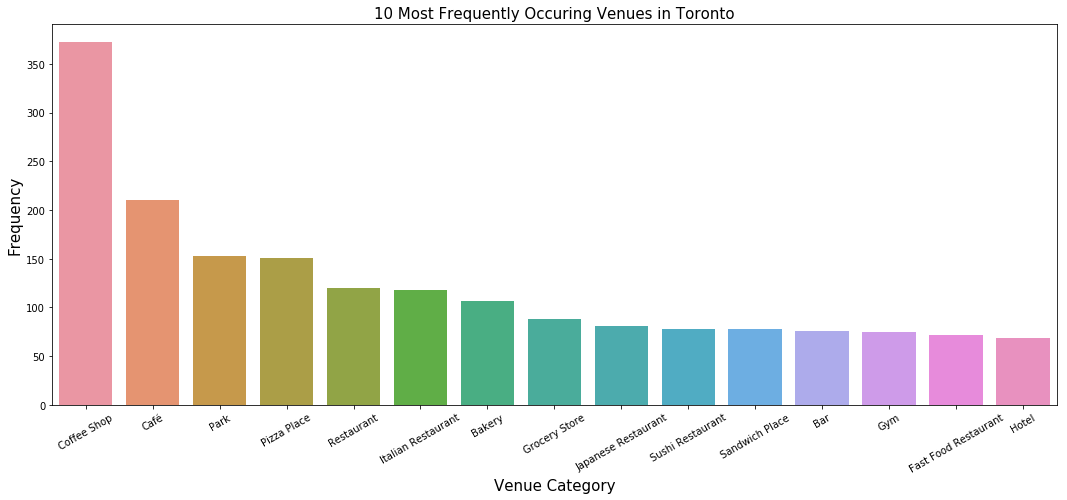

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Toronto_Venues_Top20)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in Toronto', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

After we done with the analyzing the neighborhoods, let analyze a map of Toronto with the help of Folium library.

## 3.2 Analyze a map of Toronto with neighborhoods superimposed on top

Drawing an interactive leaflet map using coordinate data and python library Folium.

In [56]:
import folium
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 3.3 Analyze the relationship between neighborhoods and Grocery Store

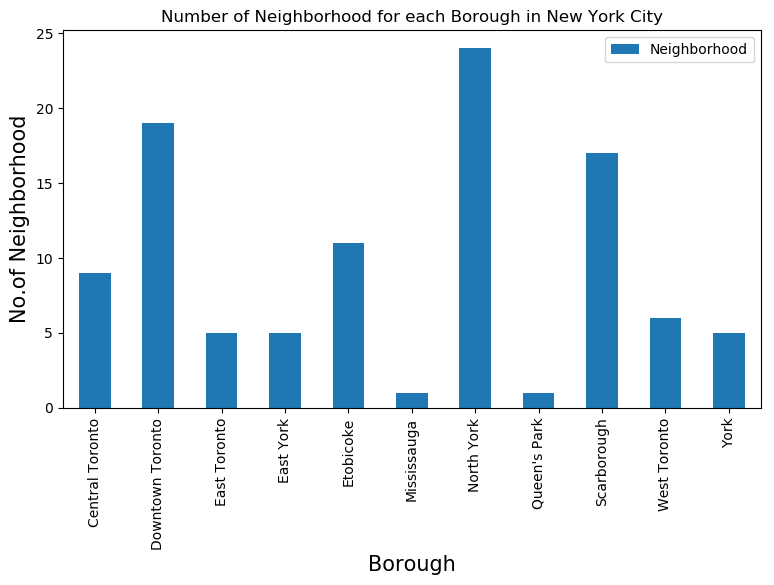

In [31]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above visualization, it is observed  that the borough North York has the highest number of neighborhoods. Next, we will prepare borough list that contains Grocery Store data for each Neighborhood.Let's try Bar plot.

In [32]:
toronto_part=toronto_grouped[['Neighborhood', 'Grocery Store']]
toronto_part.head()

,Neighborhood,Grocery Store
0,"Adelaide, King, Richmond",0.000000
1,Agincourt,0.019231
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.166667
4,"Alderwood, Long Branch",0.038462


In [34]:
#NG
toronto_part=toronto_grouped[['Neighborhood', 'Grocery Store']]
toronto_part.max()

Neighborhood     York Mills West
Grocery Store           0.166667
dtype: object

In [35]:
toronto_merged = pd.merge(df_toronto, toronto_part, on='Neighborhood')
toronto_merged.max()

Borough                     York
Postalcode                   M9W
Neighborhood     York Mills West
Latitude                 43.8153
Longitude               -79.1605
Grocery Store           0.166667
dtype: object

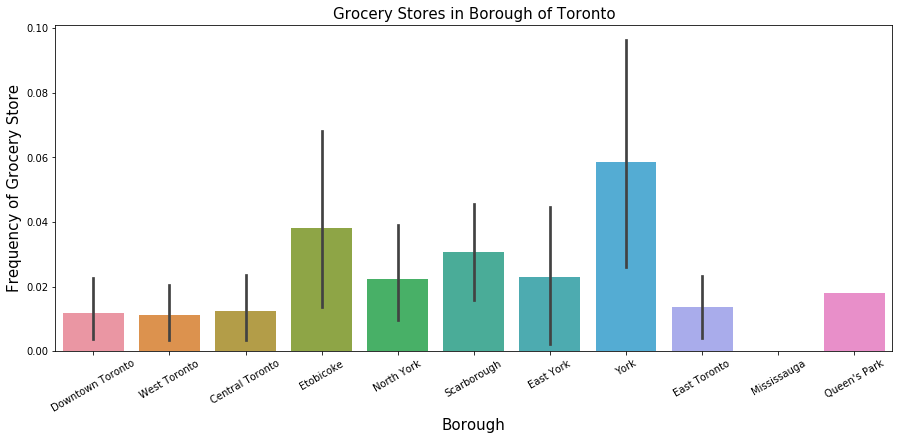

In [54]:
##%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,6))
s=sns.barplot(y="Grocery Store", x="Borough", data=toronto_merged);
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Grocery Stores in Borough of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Grocery Store", fontsize=15)
plt.show()

From the above visualization, it is being observed that the borough "York" has the highest number of grocery stores. This analysis can further be verified by extracting the information from the dataframe toronto_grouped and the dataframe toronto_merged. The information we get is which borough and which neighborhood has the maximum number of Grocery stores. Thus, the analysis showed that borough "York", and its neighbourhood  "Etobicake" have max number of Grocery Store.

Look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

# 4. Predictive Modeling

## 4.1 Cluster the  Neighborhoods of Toronto:

First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with Grocery Store percentage (i.e.toronto_grocerystore dataframe).

**Determine the optimal number of clusters for k-means clustering**

The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

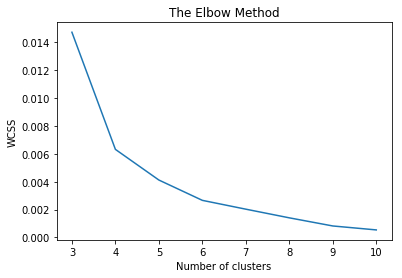

In [36]:
# Using the elbow method to find the optimal number of clusters
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_clustering = toronto_part.drop('Neighborhood', 1)


wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()


**After analyzing using elbow method it is found that K = 5 is the best value. Clustering the Toronto Neighborhood Using K-Means with K =5*

## 4.2 Examining the Clusters

We have total of 6 clusters such as 0,1,2,3,4,5. Let us examine one after the other.
Run k-means to cluster the neighborhood into 5 clusters.

In [37]:
#set number of clusters
kclusters = 5

toronto_clustering = toronto_part.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 2, 3, 2, 0, 3, 4, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2,
       0, 2, 4, 0, 1, 0, 0, 0, 4, 3, 0, 0, 0, 4, 0, 4, 0, 0, 1, 0, 0, 4,
       0, 0, 0, 3, 2, 4, 0, 0, 4, 0, 2, 2, 0, 0, 1, 0, 2, 1, 4, 0, 2, 0,
       1, 2, 2, 0, 0, 0, 4, 2, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 4, 4,
       4, 0, 0, 1, 0, 0, 1, 4, 0, 0, 0, 0, 2], dtype=int32)

In [38]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_part.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_
toronto_merged.head()

,Neighborhood,Grocery Store,Cluster Labels
0,"Adelaide, King, Richmond",0.000000,0
1,Agincourt,0.019231,4
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483,2
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.166667,3
4,"Alderwood, Long Branch",0.038462,2


In [39]:
# merge toronto_merged with df_torontoto add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(df_toronto.set_index("Neighborhood"), on="Neighborhood")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(102, 7)


,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,0,Downtown Toronto,M5H,43.650571,-79.384568
1,Agincourt,0.019231,4,Scarborough,M1S,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483,2,Scarborough,M1V,43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.166667,3,Etobicoke,M9V,43.739416,-79.588437
4,"Alderwood, Long Branch",0.038462,2,Etobicoke,M8W,43.602414,-79.543484


In [40]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

(102, 7)


,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,0,Downtown Toronto,M5H,43.650571,-79.384568
65,"Little Portugal, Trinity",0.000000,0,West Toronto,M6J,43.647927,-79.419750
63,Lawrence Park,0.000000,0,Central Toronto,M4N,43.728020,-79.388790
59,"Kingsview Village, Martin Grove Gardens, Richv...",0.000000,0,Etobicoke,M9R,43.688905,-79.554724
57,Humber Summit,0.000000,0,North York,M9L,43.756303,-79.565963
56,"Humber Bay, King's Mill Park, Kingsway Park So...",0.000000,0,Etobicoke,M8Y,43.636258,-79.498509
53,"Highland Creek, Rouge Hill, Port Union",0.000000,0,Scarborough,M1C,43.784535,-79.160497
69,North Toronto West,0.000000,0,Central Toronto,M4R,43.715383,-79.405678
51,"Harbourfront East, Toronto Islands, Union Station",0.000000,0,Downtown Toronto,M5J,43.640816,-79.381752
46,"Forest Hill North, Forest Hill West",0.000000,0,Central Toronto,M5P,43.696948,-79.411307


###  Visualize the resulting clusters

In [57]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,0,Downtown Toronto,M5H,43.650571,-79.384568
65,"Little Portugal, Trinity",0.000000,0,West Toronto,M6J,43.647927,-79.419750
63,Lawrence Park,0.000000,0,Central Toronto,M4N,43.728020,-79.388790
59,"Kingsview Village, Martin Grove Gardens, Richv...",0.000000,0,Etobicoke,M9R,43.688905,-79.554724
57,Humber Summit,0.000000,0,North York,M9L,43.756303,-79.565963
56,"Humber Bay, King's Mill Park, Kingsway Park So...",0.000000,0,Etobicoke,M8Y,43.636258,-79.498509
53,"Highland Creek, Rouge Hill, Port Union",0.000000,0,Scarborough,M1C,43.784535,-79.160497
69,North Toronto West,0.000000,0,Central Toronto,M4R,43.715383,-79.405678
51,"Harbourfront East, Toronto Islands, Union Station",0.000000,0,Downtown Toronto,M5J,43.640816,-79.381752
46,"Forest Hill North, Forest Hill West",0.000000,0,Central Toronto,M5P,43.696948,-79.411307


In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

Neighborhood      55
Grocery Store     55
Cluster Labels    55
Borough           55
Postalcode        55
Latitude          55
Longitude         55
dtype: int64

### Cluster 1

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
66,"Maryvale, Wexford",0.071429,1,Scarborough,M1R,43.750072,-79.295849
75,Rosedale,0.086957,1,Downtown Toronto,M4W,43.679563,-79.377529
61,L'Amoreaux West,0.074074,1,Scarborough,M1W,43.799525,-79.318389
40,"East Birchmount Park, Ionview, Kennedy Park",0.068966,1,Scarborough,M1K,43.727929,-79.262029
58,Humewood-Cedarvale,0.062500,1,York,M6C,43.693781,-79.428191
94,Weston,0.062500,1,York,M9N,43.706876,-79.518188
80,Scarborough Village,0.083333,1,Scarborough,M1J,43.744734,-79.239476
26,"Cloverdale, Islington, Martin Grove, Princess ...",0.062500,1,Etobicoke,M9B,43.650943,-79.554724
91,Thorncliffe Park,0.058824,1,East York,M4H,43.705369,-79.349372
10,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0.066667,1,Etobicoke,M9C,43.643515,-79.577201


In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].count()

Neighborhood      10
Grocery Store     10
Cluster Labels    10
Borough           10
Postalcode        10
Latitude          10
Longitude         10
dtype: int64

### Cluster 2

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
4,"Alderwood, Long Branch",0.038462,2,Etobicoke,M8W,43.602414,-79.543484
16,Caledonia-Fairbanks,0.043478,2,York,M6E,43.689026,-79.453512
73,Parkwoods,0.034483,2,North York,M3A,43.753259,-79.329656
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483,2,Scarborough,M1V,43.815252,-79.284577
68,"Newtonbrook, Willowdale",0.034483,2,North York,M2M,43.789053,-79.408493
48,"Guildwood, Morningside, West Hill",0.041667,2,Scarborough,M1E,43.763573,-79.188711
18,Cedarbrae,0.035714,2,Scarborough,M1H,43.773136,-79.239476
54,Hillcrest Village,0.047619,2,North York,M2H,43.803762,-79.363452
55,"Humber Bay Shores, Mimico South, New Toronto",0.052632,2,Etobicoke,M8V,43.605647,-79.501321
23,"Clairlea, Golden Mile, Oakridge",0.034483,2,Scarborough,M1L,43.711112,-79.284577


In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].count()

Neighborhood      15
Grocery Store     15
Cluster Labels    15
Borough           15
Postalcode        15
Latitude          15
Longitude         15
dtype: int64

**Cluster 3**

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.166667,3,Etobicoke,M9V,43.739416,-79.588437
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",0.125000,3,York,M6M,43.691116,-79.476013
47,Glencairn,0.111111,3,North York,M6B,43.709577,-79.445073
6,Bayview Village,0.142857,3,North York,M2K,43.786947,-79.385975


In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3].count()

Neighborhood      4
Grocery Store     4
Cluster Labels    4
Borough           4
Postalcode        4
Latitude          4
Longitude         4
dtype: int64

### Cluster 4

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
74,Queen's Park,0.017857,4,Queen's Park,M9A,43.667856,-79.532242
1,Agincourt,0.019231,4,Scarborough,M1S,43.794200,-79.262029
37,Downsview Northwest,0.032258,4,North York,M3N,43.761631,-79.520999
95,Willowdale South,0.020000,4,North York,M2N,43.770120,-79.408493
30,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0.025000,4,Central Toronto,M4V,43.686412,-79.400049
43,"Fairview, Henry Farm, Oriole",0.022727,4,North York,M2J,43.778517,-79.346556
88,"The Danforth West, Riverdale",0.020000,4,East Toronto,M4K,43.679557,-79.352188
62,"Lawrence Heights, Lawrence Manor",0.021739,4,North York,M6A,43.718518,-79.464763
87,"The Beaches West, India Bazaar",0.023810,4,East Toronto,M4L,43.668999,-79.315572
86,The Beaches,0.024096,4,East Toronto,M4E,43.676357,-79.293031


In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4].count()

Neighborhood      18
Grocery Store     18
Cluster Labels    18
Borough           18
Postalcode        18
Latitude          18
Longitude         18
dtype: int64

## 5. Results

Now, we have reached the end of the analysis. In this section we will report all the findings from the visualization & clustering of the dataset. We have found out that: 
- From the bar plot in visualization section, we found that out of 11 boroughs only York, Etobicoke, Scarborough , North York & East York have large amount of Grocery stores. However, Downtown Toronto, Central Toronto, West Toronto, Queen's Park, east Toronto & Mississauga have less number of Grocery stores.
- From the visualization section, it is also being analyzed that it wont be a good decision to open a grocery store in York and Etobicake due to large amount of grocery stores. Also, from the clustering section, it is being observed that the above specified borough and neighborhood lies in Cluster 0. 
- From the clustering section, we examined that cluster 0  has very low number to totally no grocery stores in the neighborhoods. So it is better idea to open a new grocery store in the neighborhoods which  belongs to cluster 0.